<a href="https://colab.research.google.com/github/MEGHANASAIP/Multimodal-Emotion-detection-app/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Run this first. It may take a minute to install.
!pip -q install transformers librosa soundfile pillow matplotlib


In [14]:
import torch
import numpy as np
from PIL import Image
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import torch.nn.functional as F

from transformers import (
    AutoProcessor,
    AutoModelForImageClassification,
    Wav2Vec2Processor,
    AutoModelForAudioClassification,
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

print("Torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Torch: 2.8.0+cu126
Device: cpu


In [16]:
# ------------------- FACE MODEL (DeepFace) -------------------
!pip -q install deepface
from deepface import DeepFace

def predict_face(img_path):
    # DeepFace analyze face emotions (returns %)
    preds = DeepFace.analyze(img_path, actions=['emotion'], enforce_detection=False)
    emotions = preds[0]['emotion']  # dict of emotions with %
    mapped = {k.lower(): v/100.0 for k,v in emotions.items()}  # convert % -> prob
    return mapped

print("Face model (DeepFace) loaded ✅")

# ------------------- AUDIO MODEL (Wav2Vec2 Emotion) -------------------
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

AUDIO_MODEL = "superb/wav2vec2-base-superb-er"
audio_extractor = AutoFeatureExtractor.from_pretrained(AUDIO_MODEL)
audio_model = AutoModelForAudioClassification.from_pretrained(AUDIO_MODEL).to(device)
audio_labels = {int(k): v for k,v in audio_model.config.id2label.items()}

print("Audio model loaded ✅:", len(audio_labels), "labels ->", list(audio_labels.values()))

# ------------------- TEXT MODEL (GoEmotions) -------------------
from transformers import AutoTokenizer, AutoModelForSequenceClassification

TEXT_MODEL = "bhadresh-savani/bert-base-go-emotion"
text_tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
text_model = AutoModelForSequenceClassification.from_pretrained(TEXT_MODEL).to(device)
text_labels = {int(k): v for k,v in text_model.config.id2label.items()}

print("Text model loaded ✅:", len(text_labels), "labels ->", list(text_labels.values())[:10])


Face model (DeepFace) loaded ✅
Audio model loaded ✅: 4 labels -> ['neu', 'hap', 'ang', 'sad']
Text model loaded ✅: 28 labels -> ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment']


In [17]:
import torch.nn.functional as F
import numpy as np
import librosa, soundfile as sf

# --- Audio prediction ---
def predict_audio(audio_path, target_sr=16000):
    speech, sr = sf.read(audio_path)
    if speech.ndim > 1:
        speech = speech.mean(axis=1)  # stereo → mono
    if sr != target_sr:
        speech = librosa.resample(speech, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    inputs = audio_extractor(speech, sampling_rate=sr, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = audio_model(**inputs).logits
        probs = F.softmax(logits, dim=-1).cpu().numpy()[0]

    mapped = {}
    for i,p in enumerate(probs):
        lab = audio_labels[i].lower()
        if "neu" in lab: mapped["neutral"] = float(p)
        elif "hap" in lab: mapped["happy"] = float(p)
        elif "ang" in lab: mapped["anger"] = float(p)
        elif "sad" in lab: mapped["sad"] = float(p)
    return mapped

# --- Text prediction ---
def predict_text(text):
    inputs = text_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        logits = text_model(**inputs).logits
        probs = F.softmax(logits, dim=-1).cpu().numpy()[0]

    mapped = {}
    for i,p in enumerate(probs):
        lab = text_labels[i].lower()
        if "anger" in lab: mapped["anger"] = mapped.get("anger",0)+float(p)
        elif "sad" in lab: mapped["sad"] = mapped.get("sad",0)+float(p)
        elif "happy" in lab or "amusement" in lab or "joy" in lab: mapped["happy"] = mapped.get("happy",0)+float(p)
        elif "neutral" in lab: mapped["neutral"] = mapped.get("neutral",0)+float(p)
        elif "fear" in lab: mapped["fear"] = mapped.get("fear",0)+float(p)
        elif "surprise" in lab: mapped["surprise"] = mapped.get("surprise",0)+float(p)
        elif "disgust" in lab: mapped["disgust"] = mapped.get("disgust",0)+float(p)
    return mapped

# --- Fusion function ---
COMMON = ["anger","disgust","fear","happy","sad","surprise","neutral"]

def fuse_predictions(face_map, audio_map, text_map, w_face=0.4, w_audio=0.3, w_text=0.3):
    fused = {c:0.0 for c in COMMON}
    for c in COMMON:
        fused[c] += w_face * face_map.get(c,0.0)
        fused[c] += w_audio * audio_map.get(c,0.0)
        fused[c] += w_text * text_map.get(c,0.0)
    # normalize
    s = sum(fused.values()) or 1.0
    for k in fused: fused[k] = fused[k]/s
    pred = max(fused, key=fused.get)
    return pred, fused

def pretty_print(scores):
    items = sorted(scores.items(), key=lambda x:-x[1])
    for k,v in items[:5]:
        print(f"{k:>8}: {v:.3f}")


Upload FACE image (jpg/png):


Saving happy.jpeg to happy (1).jpeg
Upload AUDIO file (wav, 1–10s recommended):


Saving audio1.opus to audio1.opus
Enter a short sentence: i am happy now but have to grow further and get good placements
25-08-28 13:34:23 - 🔗 facial_expression_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5 to /root/.deepface/weights/facial_expression_model_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 50.7MB/s]



--- Face Prediction ---
   happy: 0.941
     sad: 0.040
    fear: 0.012
 neutral: 0.007
   angry: 0.000

--- Audio Prediction ---
 neutral: 0.944
     sad: 0.044
   happy: 0.011
   anger: 0.000

--- Text Prediction ---
   happy: 0.694
 neutral: 0.019
     sad: 0.017
   anger: 0.002
surprise: 0.001

=== FINAL FUSED EMOTION ===
   happy: 0.639
 neutral: 0.317
     sad: 0.038
    fear: 0.005
   anger: 0.001
Final Prediction: HAPPY


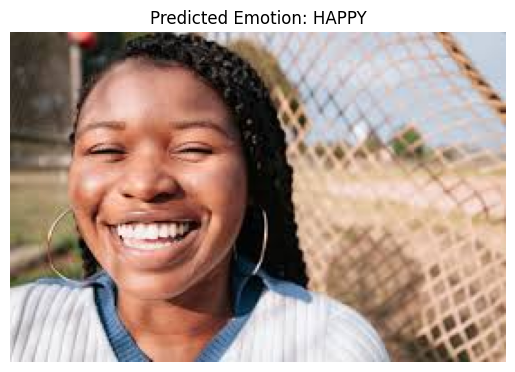

In [18]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Upload files
print("Upload FACE image (jpg/png):")
img_up = files.upload()
print("Upload AUDIO file (wav, 1–10s recommended):")
aud_up = files.upload()

img_path = list(img_up.keys())[0]
aud_path = list(aud_up.keys())[0]

# Enter text
user_text = input("Enter a short sentence: ")

# Run predictions
face_map = predict_face(img_path)
audio_map = predict_audio(aud_path)
text_map = predict_text(user_text)

print("\n--- Face Prediction ---")
pretty_print(face_map)
print("\n--- Audio Prediction ---")
pretty_print(audio_map)
print("\n--- Text Prediction ---")
pretty_print(text_map)

# Fuse
final_pred, fused = fuse_predictions(face_map, audio_map, text_map)
print("\n=== FINAL FUSED EMOTION ===")
pretty_print(fused)
print("Final Prediction:", final_pred.upper())

# Show image with result
img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted Emotion: {final_pred.upper()}")
plt.show()


In [19]:
# Try different weights for fusion (face, audio, text)
for w_face, w_audio, w_text in [(0.5,0.3,0.2), (0.3,0.4,0.3), (0.2,0.2,0.6)]:
    pred, fused_scores = fuse_predictions(face_map, audio_map, text_map,
                                          w_face=w_face, w_audio=w_audio, w_text=w_text)
    print(f"Weights F/A/T = {w_face}/{w_audio}/{w_text} -> Prediction: {pred.upper()}")
    pretty_print(fused_scores)
    print("-"*50)


Weights F/A/T = 0.5/0.3/0.2 -> Prediction: HAPPY
   happy: 0.647
 neutral: 0.307
     sad: 0.039
    fear: 0.006
   anger: 0.000
--------------------------------------------------
Weights F/A/T = 0.3/0.4/0.3 -> Prediction: HAPPY
   happy: 0.538
 neutral: 0.419
     sad: 0.038
    fear: 0.004
   anger: 0.001
--------------------------------------------------
Weights F/A/T = 0.2/0.2/0.6 -> Prediction: HAPPY
   happy: 0.721
 neutral: 0.240
     sad: 0.033
    fear: 0.004
   anger: 0.001
--------------------------------------------------


In [20]:
# installs gTTS, pydub (for mp3->wav conversion), scikit-learn for evaluation, and ffmpeg
!pip -q install gTTS pydub scikit-learn
!apt-get -qq update && apt-get -qq install -y ffmpeg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.6 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [21]:
import os

base = "/content/dataset_multimodal"
emotions = {
    "happy": [
        "I am feeling fantastic today!",
        "This is the best day ever.",
        "I am so excited and joyful.",
        "I can’t stop smiling.",
        "Life feels wonderful right now."
    ],
    "sad": [
        "I feel very lonely.",
        "Everything seems hopeless.",
        "I am really down today.",
        "I miss my friends so much.",
        "I feel like crying all the time."
    ],
    "angry": [
        "Why can’t you just listen to me!",
        "I am so frustrated with this situation.",
        "This makes me so mad.",
        "I can’t control my anger anymore.",
        "Stop bothering me right now!"
    ],
    "neutral": [
        "I went to the store to buy milk.",
        "The weather is normal today.",
        "I am reading a book quietly.",
        "This is just another regular day.",
        "I am sitting in my room."
    ]
}

os.makedirs(base, exist_ok=True)
for emo in emotions:
    os.makedirs(os.path.join(base, emo), exist_ok=True)

# Save text files
for emo, sents in emotions.items():
    for i, sent in enumerate(sents, 1):
        txt_path = os.path.join(base, emo, f"{emo}{i}.txt")
        with open(txt_path, "w") as f:
            f.write(sent)

print("Text dataset created ✅  (folder: %s)" % base)


Text dataset created ✅  (folder: /content/dataset_multimodal)


In [22]:
from gtts import gTTS
from pydub import AudioSegment
import os

for emo, sents in emotions.items():
    for i, sent in enumerate(sents, 1):
        mp3_path = os.path.join(base, emo, f"{emo}{i}.mp3")
        wav_path = os.path.join(base, emo, f"{emo}{i}.wav")
        # create mp3
        tts = gTTS(sent)
        tts.save(mp3_path)
        # convert mp3 -> wav
        sound = AudioSegment.from_file(mp3_path, format="mp3")
        sound.export(wav_path, format="wav")
        # optionally remove mp3 to save space
        os.remove(mp3_path)

print("Audio dataset created ✅  (wav files generated)")


Audio dataset created ✅  (wav files generated)


In [34]:
from google.colab import files
import shutil
import os

base = "/content/dataset_multimodal"

print("Upload your files (face images, audio, or text). The filename should start with the emotion name (e.g., happy1.jpg, sad2.wav):")
uploaded = files.upload()

for fname in uploaded.keys():
    # Extract emotion prefix from filename
    # Assumes filenames like 'happy1.jpg', 'sad2.txt', 'angry3.wav', 'neutral4.jpg'
    emotion = fname.lower().split("1")[0].replace(".jpg","").replace(".wav","").replace(".txt","")
    if emotion not in ['happy', 'sad', 'angry', 'neutral']:
        # fallback: try to parse emotion from the start of filename
        for emo in ['happy', 'sad', 'angry', 'neutral']:
            if fname.lower().startswith(emo):
                emotion = emo
                break

    dst_dir = os.path.join(base, emotion)
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    dst = os.path.join(dst_dir, fname)
    shutil.move(fname, dst)
    print(f"Moved {fname} to {dst_dir}")

print("\nUpload and organization complete! You can repeat this cell to upload more files.")


Upload your files (face images, audio, or text). The filename should start with the emotion name (e.g., happy1.jpg, sad2.wav):


Saving neutral1.jpg to neutral1.jpg
Saving angry5.jpeg to angry5.jpeg
Saving angry4.jpeg to angry4.jpeg
Saving angry3.jpeg to angry3.jpeg
Saving angry2.jpeg to angry2.jpeg
Saving angry1.jpeg to angry1.jpeg
Saving neutral5.jpg to neutral5.jpg
Saving neutral4.jpg to neutral4.jpg
Saving neutral3.jpg to neutral3.jpg
Saving neutral2.jpg to neutral2.jpg
Saving sad5.jpg to sad5.jpg
Saving sad4.jpg to sad4.jpg
Saving sad3.jpg to sad3.jpg
Saving sad2.jpg to sad2.jpg
Saving sad1.jpg to sad1.jpg
Saving happy5.jpg to happy5.jpg
Saving happy4.jpg to happy4.jpg
Saving happy3.jpg to happy3.jpg
Saving happy2.jpg to happy2.jpg
Saving happy1.jpg to happy1.jpg
Moved neutral1.jpg to /content/dataset_multimodal/neutral
Moved angry5.jpeg to /content/dataset_multimodal/angry
Moved angry4.jpeg to /content/dataset_multimodal/angry
Moved angry3.jpeg to /content/dataset_multimodal/angry
Moved angry2.jpeg to /content/dataset_multimodal/angry
Moved angry1.jpeg to /content/dataset_multimodal/angry
Moved neutral5.jp

In [35]:
import os

base = "/content/dataset_multimodal"
emotions = ["happy", "sad", "angry", "neutral"]

for emo in emotions:
    folder = os.path.join(base, emo)
    files = sorted(os.listdir(folder))
    print(f"\nFiles in {emo} folder:")
    for f in files:
        print("  ", f)



Files in happy folder:
   happy1.jpg
   happy1.txt
   happy1.wav
   happy2.jpg
   happy2.txt
   happy2.wav
   happy3.jpg
   happy3.txt
   happy3.wav
   happy4.jpg
   happy4.txt
   happy4.wav
   happy5.jpg
   happy5.txt
   happy5.wav

Files in sad folder:
   sad1.jpg
   sad1.txt
   sad1.wav
   sad2.jpg
   sad2.txt
   sad2.wav
   sad3.jpg
   sad3.txt
   sad3.wav
   sad4.jpg
   sad4.txt
   sad4.wav
   sad5.jpg
   sad5.txt
   sad5.wav

Files in angry folder:
   angry1.jpeg
   angry1.txt
   angry1.wav
   angry2.jpeg
   angry2.txt
   angry2.wav
   angry3.jpeg
   angry3.txt
   angry3.wav
   angry4.jpeg
   angry4.txt
   angry4.wav
   angry5.jpeg
   angry5.txt
   angry5.wav

Files in neutral folder:
   neutral1.jpg
   neutral1.txt
   neutral1.wav
   neutral2.jpg
   neutral2.txt
   neutral2.wav
   neutral3.jpg
   neutral3.txt
   neutral3.wav
   neutral4.jpg
   neutral4.txt
   neutral4.wav
   neutral5.jpg
   neutral5.txt
   neutral5.wav


Accuracy: 0.55

Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
       angry       0.00      0.00      0.00         5
     disgust       0.00      0.00      0.00         0
       happy       0.50      0.80      0.62         5
     neutral       0.57      0.80      0.67         5
         sad       1.00      0.60      0.75         5

    accuracy                           0.55        20
   macro avg       0.35      0.37      0.34        20
weighted avg       0.52      0.55      0.51        20



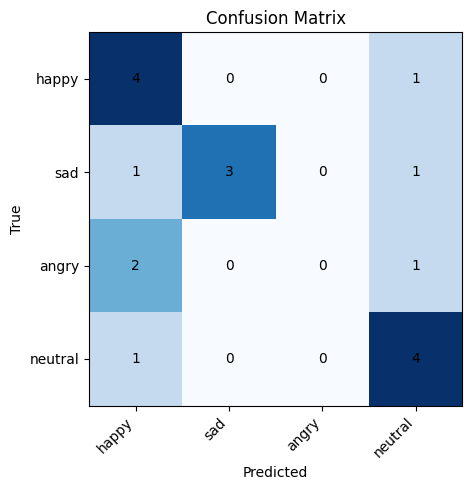

In [37]:

import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

base = "/content/dataset_multimodal"
emotions = ["happy", "sad", "angry", "neutral"]

y_true = []
y_pred = []

for emo in emotions:
    folder = os.path.join(base, emo)
    txt_files = [f for f in os.listdir(folder) if f.endswith(".txt")]

    for txt_file in txt_files:
        prefix = txt_file[:-4]  # remove '.txt' to get sample prefix like 'happy1'

        # Find face image path: check .jpg first, then .jpeg
        jpg_path = os.path.join(folder, prefix + ".jpg")
        jpeg_path = os.path.join(folder, prefix + ".jpeg")
        if os.path.exists(jpg_path):
            img_path = jpg_path
        elif os.path.exists(jpeg_path):
            img_path = jpeg_path
        else:
            raise FileNotFoundError(f"No face image found for {prefix} with .jpg or .jpeg extension")

        wav_path = os.path.join(folder, prefix + ".wav")
        txt_path = os.path.join(folder, txt_file)

        with open(txt_path, "r") as f:
            text = f.read().strip()

        # Run models (make sure predict_face, predict_audio, predict_text, fuse_predictions are loaded)
        face_map = predict_face(img_path)
        audio_map = predict_audio(wav_path)
        text_map = predict_text(text)
        pred, _ = fuse_predictions(face_map, audio_map, text_map)

        y_true.append(emo)
        y_pred.append(pred)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=emotions)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xticks(np.arange(len(emotions)))
ax.set_yticks(np.arange(len(emotions)))
ax.set_xticklabels(emotions)
ax.set_yticklabels(emotions)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(len(emotions)):
    for j in range(len(emotions)):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()
